In [1]:
# 📦 Install Required Packages
!pip install albumentations opencv-python-headless --quiet

In [2]:
# 🔧 Imports
import os
import cv2
import torch
import numpy as np
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.ops import box_iou

In [3]:
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace('.jpg', '.txt').replace('.png', '.txt'))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))  # Resize from 640x640 → 224x224

        boxes = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                cls, x, y, w, h = map(float, line.strip().split())
                boxes.append([x, y, w, h, cls])

        boxes = np.array(boxes)

        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, class_labels=[b[4] for b in boxes])
            image = transformed['image']
            boxes = transformed['bboxes']

        return image, boxes

##  Define Custom CNN Model for Object Detection

In [4]:
import torch.nn as nn

class SimpleObjectDetector(nn.Module):
    def __init__(self, num_classes):
        super(SimpleObjectDetector, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 208x208
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 104x104
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 52x52
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # Force feature map to 128x4x4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                    # 128 * 4 * 4 = 2048
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes + 4)  # 4 for bbox (x, y, w, h) + class
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## Define Custom Loss Function

In [5]:
def detection_loss(predictions, targets, lambda_coord=5, lambda_noobj=0.5):
    # Simplified example
    bbox_pred = predictions[:, :4]  # x, y, w, h
    class_pred = predictions[:, 4:]  # class logits
    
    bbox_target = targets[:, :4]
    class_target = targets[:, 4].long()

    bbox_loss = nn.MSELoss()(bbox_pred, bbox_target)
    class_loss = nn.CrossEntropyLoss()(class_pred, class_target)

    return lambda_coord * bbox_loss + class_loss

##  Training Loop

In [6]:
def train_model(model, dataloader, optimizer, device, epochs=5):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, targets in dataloader:
            images = images.permute(0, 3, 1, 2).float().to(device) / 255.0
            targets = torch.tensor(targets).float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = detection_loss(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.4f}")

##  Evaluation Metrics and Utilities

In [7]:
from torchvision.ops import box_iou
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)
    iou_scores = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.permute(0, 3, 1, 2).float().to(device) / 255.0
            targets = torch.tensor(targets).float().to(device)
            outputs = model(images)

            pred_boxes = outputs[:, :4]
            target_boxes = targets[:, :4]

            pred_labels = torch.argmax(outputs[:, 4:], dim=1).cpu()
            target_labels = targets[:, 4].long().cpu()

            ious = box_iou(pred_boxes, target_boxes).diag().cpu().numpy()
            iou_scores.extend(ious)
            all_preds.extend(pred_labels)
            all_targets.extend(target_labels)

    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    mean_iou = np.mean(iou_scores)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Mean IoU: {mean_iou:.4f}")

##  Visualization: Plot Sample Predictions

In [8]:
def plot_sample_prediction(model, dataset, index, device):
    model.eval()
    image, targets = dataset[index]
    image_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0

    with torch.no_grad():
        output = model(image_tensor)[0].cpu()

    pred_box = output[:4].detach().numpy()
    pred_class = torch.argmax(output[4:]).item()

    h, w = image.shape[:2]
    cx, cy, bw, bh = pred_box * [w, h, w, h]
    x1, y1, x2, y2 = int(cx - bw / 2), int(cy - bh / 2), int(cx + bw / 2), int(cy + bh / 2)

    image_copy = image.copy()
    cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_copy, f"Pred: {pred_class}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(image_copy)
    plt.axis('off')
    plt.title("Prediction Visualization")
    plt.show()

##  Plot Training Loss Curve

In [9]:
def plot_loss_curve(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

##  Run Training, Evaluation & Plot Predictions

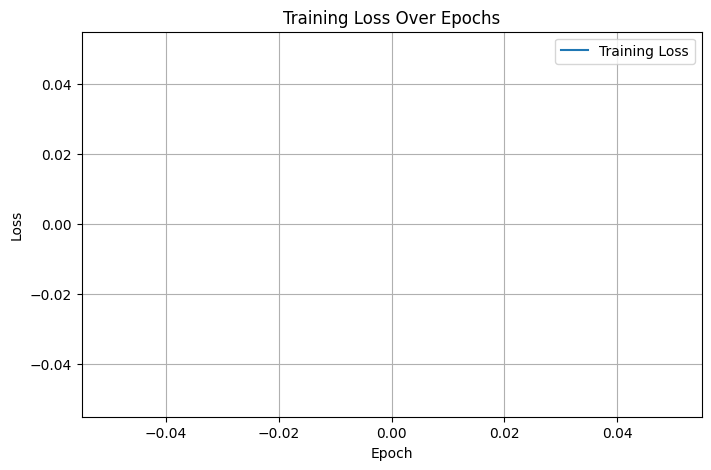

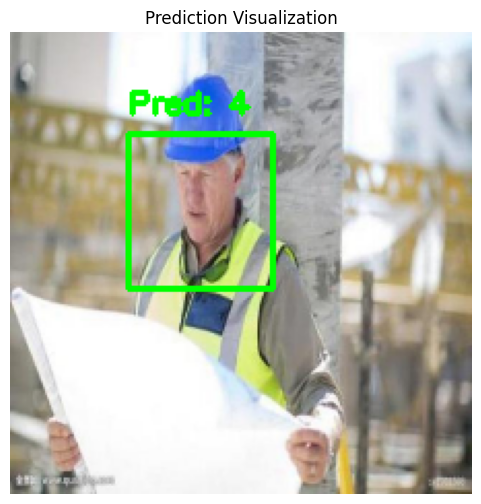

Figure 1: Predicted bounding box drawn on image


In [10]:
def yolo_collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        images.append(torch.tensor(img))
        targets.append(torch.tensor(target))
        transform=None
    return images, targets

train_dataset = YoloDataset(
    image_dir=r'C:\Users\Priyanka\Desktop\Masters\Masters assignment 2\DAML\PPE_Detection-2\train\images',
    label_dir=r'C:\Users\Priyanka\Desktop\Masters\Masters assignment 2\DAML\PPE_Detection-2\train\labels',
    transform=None
    
)
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=yolo_collate_fn
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleObjectDetector(num_classes=7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
model.to(device)
for epoch in range(1):  

    epoch_loss = 0.0
for images, targets in train_loader:
    images = torch.stack([
        img.permute(2, 0, 1).float() / 255.0
        for img in images
    ]).to(device)

    targets = [t.float().to(device) for t in targets]

    optimizer.zero_grad()
    outputs = model(images)

    # Use only one box per image (simplified)
    batch_targets = torch.stack([t[0] for t in targets])

    loss = detection_loss(outputs, batch_targets)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

#  Plot Loss
plot_loss_curve(losses)



#  Show Sample Output
plot_sample_prediction(model, train_dataset, index=0, device=device)
print("Figure 1: Predicted bounding box drawn on image")

## Final Clean Training and Evaluation Loop

Epoch 1: Loss = 1.9774
Epoch 2: Loss = 1.6690
Epoch 3: Loss = 1.5755
Epoch 4: Loss = 1.5095
Epoch 5: Loss = 1.4583


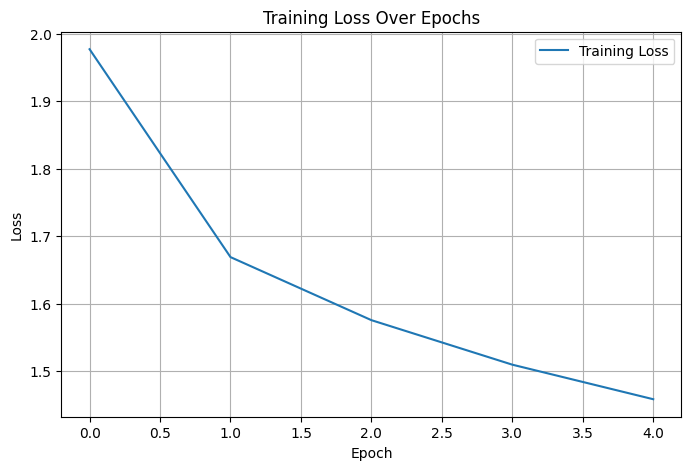

C:\Users\Priyanka\AppData\Local\Temp\ipykernel_16412\22404785.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().to(device)


RuntimeError: The size of tensor a (2) must match the size of tensor b (5) at non-singleton dimension 2

In [11]:
# Final Training Execution
import torch.nn.utils.rnn as rnn

def yolo_collate_fn(batch):
    images = []
    targets = []

    for img, target in batch:
        images.append(torch.tensor(img).float())  # Convert img to tensor and float
        targets.append(torch.tensor(target))  # Convert targets to tensor

    images = torch.stack(images)  # Stack images into a single tensor

    # Pad the targets (bounding boxes) to make them the same size
    targets = rnn.pad_sequence(targets, batch_first=True, padding_value=-1)

    return images, targets

train_dataset = YoloDataset(
    image_dir=r'C:\Users\Priyanka\Desktop\Masters\Masters assignment 2\DAML\PPE_Detection-2\train\images',
    label_dir=r'C:\Users\Priyanka\Desktop\Masters\Masters assignment 2\DAML\PPE_Detection-2\train\labels',
    transform=None
)


train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=yolo_collate_fn
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleObjectDetector(num_classes=7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
model.to(device)

for epoch in range(5):
    epoch_loss = 0.0
    model.train()

    for images, targets in train_loader:
        # Ensure images are stacked into a tensor and permuted correctly
        images = torch.stack([img.permute(2, 0, 1).float() for img in images]).to(device) / 255.0

        # Move targets to the device
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)

        # Use only one box per image (simplified)
        batch_targets = targets[:, 0]  # Use only the first bounding box (simplified)

        loss = detection_loss(outputs, batch_targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)  # Average loss per epoch
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")  # Only print once per epoch






 # 📉 Plot Loss
plot_loss_curve(losses)

# 🧪 Evaluate
evaluate_model(model, train_loader, device)

# 🖼️ Show Sample Output
plot_sample_prediction(model, train_dataset, index=0, device=device)
print("Figure 1: Predicted bounding box drawn on image")


In [12]:
# Custom CNN model for PPE detection

import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNNDetector(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNNDetector, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 26 * 26, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 4 + num_classes)  # 4 for bbox, rest for class scores
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        bbox = torch.sigmoid(x[:, :4])  # normalized bbox
        classes = F.softmax(x[:, 4:], dim=1)
        return bbox, classes


In [13]:
# Training loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNNDetector(num_classes=7).to(device)

# Dummy loss and optimizer (you need to customize this for real training)
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Dummy training loop
for epoch in range(5):  # You can increase this
    print(f"Epoch {epoch+1}/5")
    # Example inputs
    inputs = torch.randn(4, 3, 416, 416).to(device)  # Batch of 4 images
    bboxes = torch.rand(4, 4).to(device)  # Normalized bbox [x,y,w,h]
    labels = torch.randint(0, 7, (4,)).to(device)  # Class indices
    
    pred_bbox, pred_classes = model(inputs)
    
    loss_bbox = criterion_bbox(pred_bbox, bboxes)
    loss_cls = criterion_cls(pred_classes, labels)
    loss = loss_bbox + loss_cls
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Loss: {loss.item():.4f}")


Epoch 1/5
Loss: 2.0229
Epoch 2/5
Loss: 2.2782
Epoch 3/5
Loss: 2.4941
Epoch 4/5
Loss: 2.0035
Epoch 5/5
Loss: 1.9421
